<a href="https://colab.research.google.com/github/Wasan-Mohammed/movie_recommendation/blob/main/Movie_Recommendation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt
import numpy as np
import keras
from keras import layers
from keras import ops

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
rating = pd.read_csv('/content/drive/MyDrive/project-1/Movie recommendation/rating.csv')
rating.head()

,userId,movieId,rating,timestamp
0,1,2,3.5,2005-04-02 23:53:47
1,1,29,3.5,2005-04-02 23:31:16
2,1,32,3.5,2005-04-02 23:33:39
3,1,47,3.5,2005-04-02 23:32:07
4,1,50,3.5,2005-04-02 23:29:40


In [ ]:
movie = pd.read_csv('/content/drive/MyDrive/project-1/Movie recommendation/movie.csv')
movie.head()

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


# **Data preprocess**

In [ ]:
mr = pd.merge(rating, movie, how='left', on='movieId')
mr.head()

,userId,movieId,rating,timestamp,title,genres
0,1,2,3.5,2005-04-02 23:53:47,Jumanji (1995),Adventure|Children|Fantasy
1,1,29,3.5,2005-04-02 23:31:16,"City of Lost Children, The (Cité des enfants p...",Adventure|Drama|Fantasy|Mystery|Sci-Fi
2,1,32,3.5,2005-04-02 23:33:39,Twelve Monkeys (a.k.a. 12 Monkeys) (1995),Mystery|Sci-Fi|Thriller
3,1,47,3.5,2005-04-02 23:32:07,Seven (a.k.a. Se7en) (1995),Mystery|Thriller
4,1,50,3.5,2005-04-02 23:29:40,"Usual Suspects, The (1995)",Crime|Mystery|Thriller


In [ ]:
mr.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20000263 entries, 0 to 20000262
Data columns (total 6 columns):
 #   Column     Dtype  
---  ------     -----  
 0   userId     int64  
 1   movieId    int64  
 2   rating     float64
 3   timestamp  object 
 4   title      object 
 5   genres     object 
dtypes: float64(1), int64(2), object(3)
memory usage: 915.5+ MB


In [ ]:
mr.describe()

,userId,movieId,rating
count,2.000026e+07,2.000026e+07,2.000026e+07
mean,6.904587e+04,9.041567e+03,3.525529e+00
std,4.003863e+04,1.978948e+04,1.051989e+00
min,1.000000e+00,1.000000e+00,5.000000e-01
25%,3.439500e+04,9.020000e+02,3.000000e+00
50%,6.914100e+04,2.167000e+03,3.500000e+00
75%,1.036370e+05,4.770000e+03,4.000000e+00
max,1.384930e+05,1.312620e+05,5.000000e+00


In [ ]:
mr.isnull().sum()

,0
userId,0
movieId,0
rating,0
timestamp,0
title,0
genres,0


In [ ]:
mr.duplicated().sum()

np.int64(0)

In [ ]:
#drop the duplicated values but keep the lastest rating
#هنا شفت تواريخ الافلام المكرره عند كل يوزر وحذفت التكرار وخليت اخر تقييم
rating_sorted = mr.sort_values(by='timestamp', ascending=False)
rating_latest = rating_sorted.drop_duplicates(subset='movieId', keep='first')
rating_latest.head()

,userId,movieId,rating,timestamp,title,genres
12675921,87586,7151,3.5,2015-03-31 06:40:02,Girl with a Pearl Earring (2003),Drama|Romance
12898527,89081,52458,4.0,2015-03-31 06:11:28,Disturbia (2007),Drama|Thriller
12898546,89081,55232,3.5,2015-03-31 06:11:26,Resident Evil: Extinction (2007),Action|Horror|Sci-Fi|Thriller
2508834,16978,2093,3.5,2015-03-31 06:03:17,Return to Oz (1985),Adventure|Children|Fantasy
7819902,53930,118706,3.5,2015-03-31 06:00:51,Black Sea (2014),Adventure|Thriller


In [ ]:
#حذف المستخدمين الي عندهم تقيمات اقل من 10% للافلام
total_movies = mr['movieId'].nunique()
threshold = total_movies * 0.10
user_counts = mr.groupby('userId')['movieId'].nunique()
users_to_remove = user_counts[user_counts < threshold].index
rating_filtered = mr[~mr['userId'].isin(users_to_remove)]
rating_filtered.head()

,userId,movieId,rating,timestamp,title,genres
580971,3907,1,4.0,2003-10-24 05:24:32,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
580972,3907,2,2.5,2004-06-03 15:30:43,Jumanji (1995),Adventure|Children|Fantasy
580973,3907,6,4.0,2003-10-24 05:25:13,Heat (1995),Action|Crime|Thriller
580974,3907,7,2.0,2004-04-02 06:04:27,Sabrina (1995),Comedy|Romance
580975,3907,10,4.0,2003-10-24 05:48:27,GoldenEye (1995),Action|Adventure|Thriller


In [ ]:
#collect uniqe user id and movie id
user_ids = mr['userId'].unique().tolist()
movie_ids = mr['movieId'].unique().tolist()

#dectionary hold info of maping user id to its index in the list (every user will have one index not alot)
user2user_encoded = {x: i for i, x in enumerate(user_ids)}
userencoded2user = {i: x for i, x in enumerate(user_ids)}
#dectionary hold info of maping movie id to its index in the list
movie2movie_encoded = {x: i for i, x in enumerate(movie_ids)}
movie_encoded2movie = {i: x for i, x in enumerate(movie_ids)}

#new columns
mr['user'] = mr['userId'].map(user2user_encoded)
mr['movie'] = mr['movieId'].map(movie2movie_encoded)

In [ ]:
mr.head()

,userId,movieId,rating,timestamp,title,genres,user,movie
0,1,2,3.5,2005-04-02 23:53:47,Jumanji (1995),Adventure|Children|Fantasy,0,0
1,1,29,3.5,2005-04-02 23:31:16,"City of Lost Children, The (Cité des enfants p...",Adventure|Drama|Fantasy|Mystery|Sci-Fi,0,1
2,1,32,3.5,2005-04-02 23:33:39,Twelve Monkeys (a.k.a. 12 Monkeys) (1995),Mystery|Sci-Fi|Thriller,0,2
3,1,47,3.5,2005-04-02 23:32:07,Seven (a.k.a. Se7en) (1995),Mystery|Thriller,0,3
4,1,50,3.5,2005-04-02 23:29:40,"Usual Suspects, The (1995)",Crime|Mystery|Thriller,0,4


In [ ]:
num_users = len(user2user_encoded)
num_movies = len(movie2movie_encoded)
mr['rating'] = mr['rating'].values.astype(np.float32)

#min and max rating will be used to normalize the ratings later
min_rating = min(mr['rating'])
max_rating = max(mr['rating'])

print('Number of users: {}, Number of Movies: {}, Min rating: {}, Max rating: {}'.format(num_users, num_movies, min_rating, max_rating))

Number of users: 138493, Number of Movies: 26744, Min rating: 0.5, Max rating: 5.0


#Random Train-Test split

In [ ]:
mr = mr.sample(frac=1, random_state=42)
x = mr[['user', 'movie']].values
#noralize the target between 0 and 1
y = mr['rating'].apply(lambda x: (x - min_rating) / (max_rating - min_rating)).values

In [ ]:
#Assuming training on 80% of data and validating on 20%
train_indices = int(0.8 * mr.shape[0])
x_train, x_val, y_train, y_val =(x[:train_indices],x[train_indices:],y[:train_indices],y[train_indices:])

In [ ]:
print('Number of training data: {}\nNumber of validation data: {}'.format( x_train.shape, x_val.shape))

Number of training data: (16000210, 2)
Number of validation data: (4000053, 2)


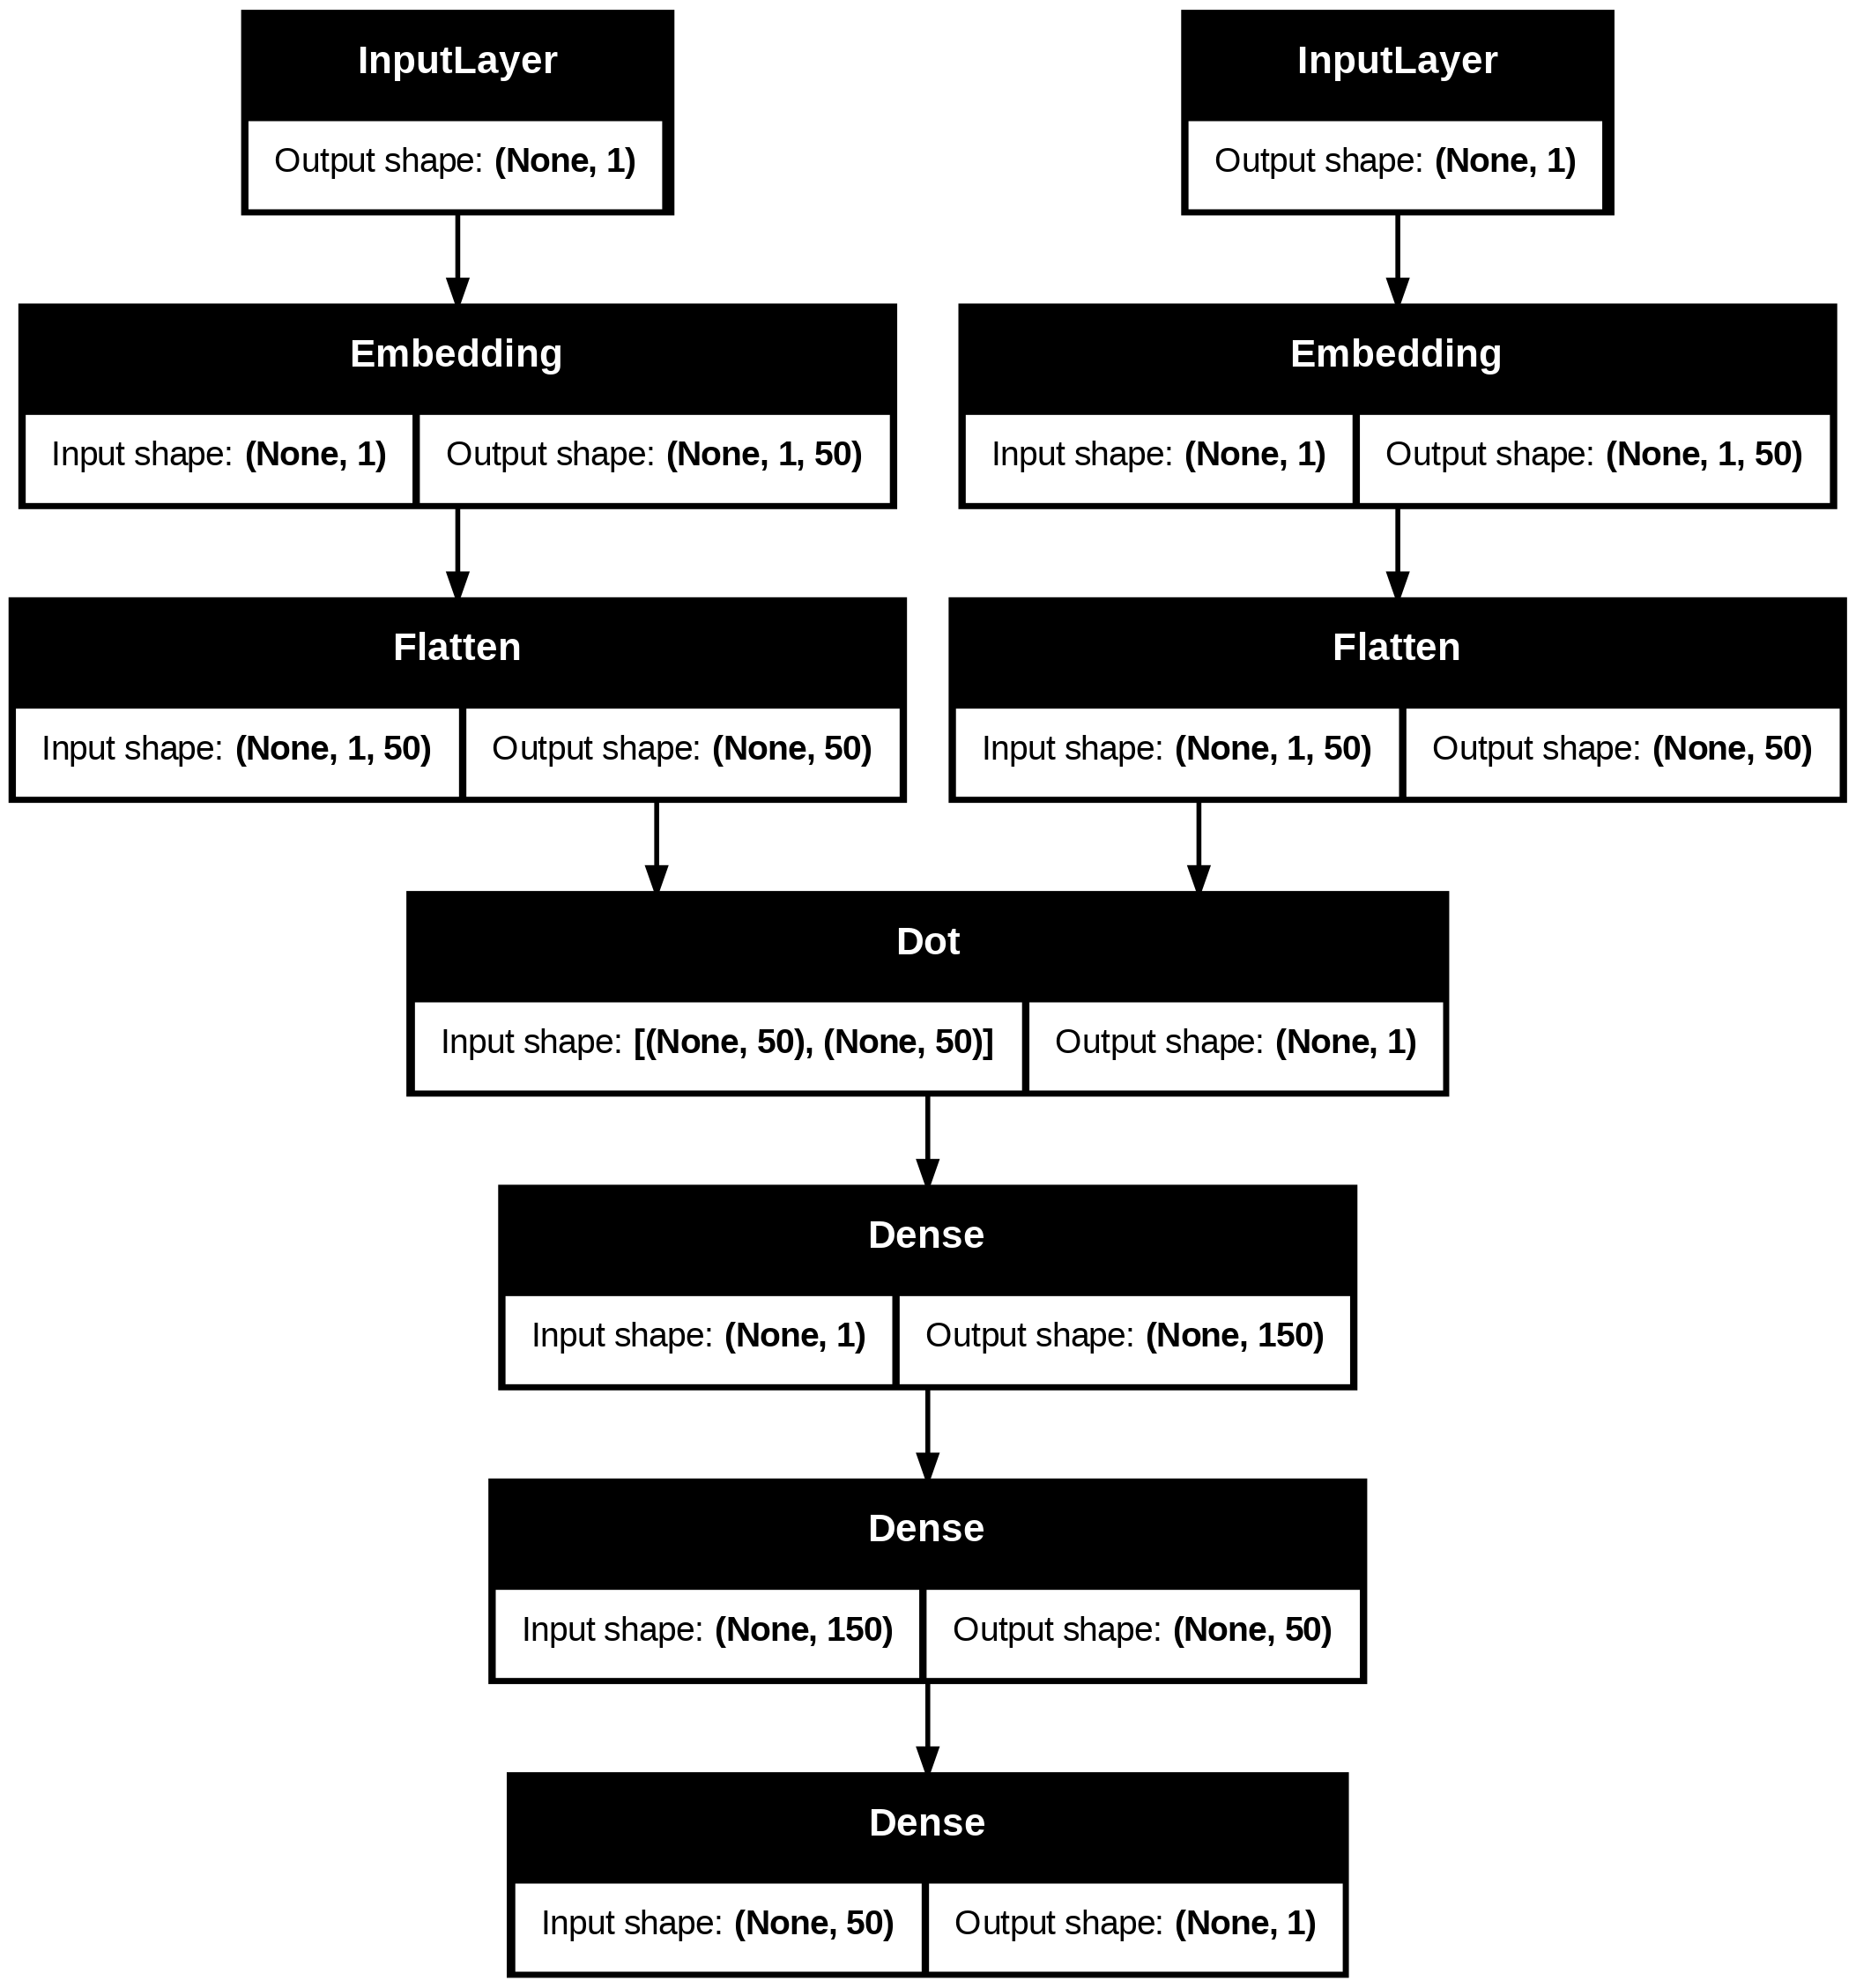

In [ ]:
from tensorflow.keras import regularizers
#defining the model
embedding_size = 50

user_ips = layers.Input(shape=[1])
user_embedding = layers.Embedding(num_users, embedding_size, embeddings_initializer ='he_normal',
                                  embeddings_regularizer=keras.regularizers.l2(1e-6))(user_ips)

user_vect= layers.Flatten()(user_embedding)

movie_ips = layers.Input(shape=[1])
movie_embedding = layers.Embedding(num_movies, embedding_size, embeddings_initializer='he_normal',
                                   embeddings_regularizer=keras.regularizers.l2(1e-6))(movie_ips)
movie_vect= layers.Flatten()(movie_embedding)

prod = layers.Dot(axes=1)([user_vect, movie_vect])

d1 = layers.Dense(150, kernel_initializer='he_normal')(prod)
d2 = layers.Dense(50, kernel_initializer='he_normal')(d1)
d3 = layers.Dense(1, kernel_regularizer=regularizers.l2(0.001))(d2)

model= keras.Model([user_ips, movie_ips], d3)
model.compile(optimizer='adam', loss='mean_squared_error')

keras.utils.plot_model(model, show_shapes=True)

In [ ]:
history = model.fit(
    [x_train[:,0], x_train[:,1]],
    y_train,
    batch_size=4000,
    epochs=10,
    validation_data=([x_val[:,0], x_val[:,1]], y_val),
    verbose=1
)

Epoch 1/10
4001/4001 ━━━━━━━━━━━━━━━━━━━━ 27s 6ms/step - loss: 0.0521 - val_loss: 0.0395
Epoch 2/10
4001/4001 ━━━━━━━━━━━━━━━━━━━━ 19s 5ms/step - loss: 0.0378 - val_loss: 0.0397
Epoch 3/10
4001/4001 ━━━━━━━━━━━━━━━━━━━━ 20s 5ms/step - loss: 0.0366 - val_loss: 0.0395
Epoch 4/10
4001/4001 ━━━━━━━━━━━━━━━━━━━━ 19s 5ms/step - loss: 0.0360 - val_loss: 0.0395
Epoch 5/10
4001/4001 ━━━━━━━━━━━━━━━━━━━━ 20s 5ms/step - loss: 0.0358 - val_loss: 0.0391
Epoch 6/10
4001/4001 ━━━━━━━━━━━━━━━━━━━━ 19s 5ms/step - loss: 0.0356 - val_loss: 0.0392
Epoch 7/10
4001/4001 ━━━━━━━━━━━━━━━━━━━━ 20s 5ms/step - loss: 0.0355 - val_loss: 0.0390
Epoch 8/10
4001/4001 ━━━━━━━━━━━━━━━━━━━━ 19s 5ms/step - loss: 0.0354 - val_loss: 0.0388
Epoch 9/10
4001/4001 ━━━━━━━━━━━━━━━━━━━━ 20s 5ms/step - loss: 0.0353 - val_loss: 0.0391
Epoch 10/10
4001/4001 ━━━━━━━━━━━━━━━━━━━━ 19s 4ms/step - loss: 0.0353 - val_loss: 0.0387


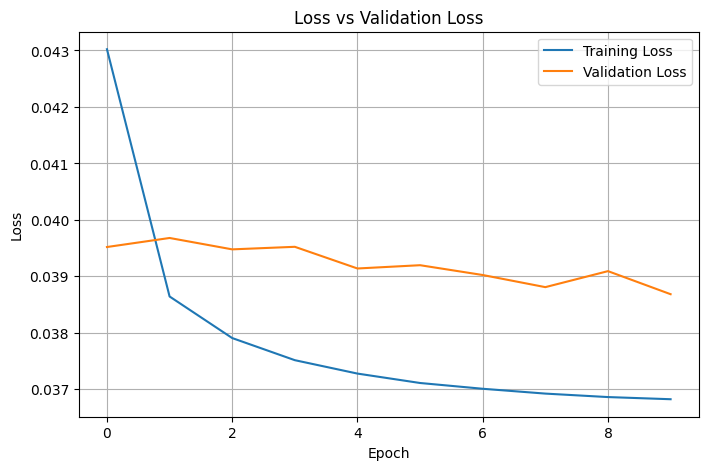

In [ ]:

loss = history.history['loss']
val_loss = history.history.get('val_loss')

plt.figure(figsize=(8,5))
plt.plot(loss, label='Training Loss')

if val_loss is not None:
    plt.plot(val_loss, label='Validation Loss')

plt.title("Loss vs Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)
plt.show()


In [ ]:
# loss = history.history['accuracy']
# val_loss = history.history.get('val_accuracy')

# plt.figure(figsize=(8,5))
# plt.plot(loss, label='Training accuracy')

# if val_loss is not None:
#     plt.plot(val_loss, label='Validation accuracy')

# plt.title("accuracy vs Validation accuracy")
# plt.xlabel("Epoch")
# plt.ylabel("Loss")
# plt.legend()
# plt.grid(True)
# plt.show()

In [ ]:
#predict rating
pred = model.predict([x_train[4:5,0], x_train[4:5,1]])
print("Predicted rating:", pred[0][0])

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 248ms/step
Predicted rating: 0.48079234


In [ ]:
user_id = mr.userId.sample(1).iloc[0]
movies_watched_by_user = mr[mr.userId == user_id]
movies_not_watched = mr[~mr['movieId'].isin(movies_watched_by_user.movieId.values)]['movieId']

In [ ]:
user_id

np.int64(83863)

In [ ]:
movies_watched_by_user.head()

,userId,movieId,rating,timestamp,title,genres,user,movie
12139691,83863,49274,2.0,2008-05-30 08:05:29,Happy Feet (2006),Adventure|Animation|Children|Comedy|IMAX,83862,1785
12139724,83863,60069,4.0,2011-02-09 22:50:46,WALL·E (2008),Adventure|Animation|Children|Romance|Sci-Fi,83862,1007
12139589,83863,5479,3.5,2008-06-04 20:21:20,K-19: The Widowmaker (2002),Action|Adventure|Drama|Thriller,83862,5587
12139753,83863,79293,4.5,2011-02-14 19:26:29,Salt (2010),Action|Thriller,83862,2794
12139723,83863,59784,4.0,2010-01-08 16:36:44,Kung Fu Panda (2008),Action|Animation|Children|Comedy|IMAX,83862,1805


In [ ]:
movies_not_watched

,movieId
12970708,109374
15426752,1060
6934678,1732
1672921,504
7224086,1792
...,...
10526850,415
9628519,3296
2234489,2717
13315092,1276


In [ ]:
#inner join : filtering the movies not in the training
movies_not_watched = list(set(movies_not_watched).intersection(set(movie2movie_encoded.keys())))

In [ ]:
movies_not_watched_index = [[movie2movie_encoded.get(x)] for x in movies_not_watched]

In [ ]:
user_encoder = user2user_encoded.get(user_id)

In [ ]:
user_movie_array = np.hstack(([[user_encoder]] * len(movies_not_watched), movies_not_watched_index))
user_movie_array

array([[83862, 23878],
       [83862, 23879],
       [83862,   175],
       ...,
       [83862, 23875],
       [83862, 23876],
       [83862, 23877]])

In [ ]:
ratings = model.predict([user_movie_array[:,0],user_movie_array[:,1]]).flatten()
ratings

823/823 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step


array([0.64120483, 0.64138234, 0.434456  , ..., 0.63779354, 0.64120483,
       0.64120483], dtype=float32)

In [ ]:
top_ratings_indices = ratings.argsort()[-10:][::-1]

In [ ]:
recommended_movie_ids = [movie_encoded2movie.get(movies_not_watched_index[x][0]) for x in top_ratings_indices]

In [ ]:
print("Recommendation for user: {}". format(user_id))
print("====" * 9)
print("Movies with high ratings from user")
print("----" * 9)
top_movies_user = (
    movies_watched_by_user.sort_values(by="rating", ascending=False)
    .movieId.values
)
movie_mr_rows = mr[mr["movieId"].isin(top_movies_user)]
for row in movie_mr_rows.head(10).itertuples():
  print(row.title, ":", row.genres)

Recommendation for user: 83863
Movies with high ratings from user
------------------------------------
Shrek 2 (2004) : Adventure|Animation|Children|Comedy|Musical|Romance
Twelve Monkeys (a.k.a. 12 Monkeys) (1995) : Mystery|Sci-Fi|Thriller
My Cousin Vinny (1992) : Comedy
Meet Joe Black (1998) : Romance
Fish Called Wanda, A (1988) : Comedy|Crime
Independence Day (a.k.a. ID4) (1996) : Action|Adventure|Sci-Fi|Thriller
Nine Months (1995) : Comedy|Romance
Mr. Holland's Opus (1995) : Drama
Wimbledon (2004) : Comedy|Romance
Aladdin (1992) : Adventure|Animation|Children|Comedy|Musical


In [ ]:
print("----" * 8)
print("Top 10 movie recommendations")
print("----" * 8)
recommended_movies = mr[mr["movieId"].isin(recommended_movie_ids)]
recommended_movies = recommended_movies.drop_duplicates(subset="movieId")
for row in recommended_movies.head(10).itertuples():
    print(row.title, ":", row.genres)

--------------------------------
Top 10 movie recommendations
--------------------------------
Radio (2003) : Drama
Black Book (Zwartboek) (2006) : Drama|Thriller|War
Life as a House (2001) : Drama
My Neighbor Totoro (Tonari no Totoro) (1988) : Animation|Children|Drama|Fantasy
Mighty, The (1998) : Drama
Brokedown Palace (1999) : Drama
Antwone Fisher (2002) : Drama
Dangerous Beauty (1998) : Drama
What the #$*! Do We Know!? (a.k.a. What the Bleep Do We Know!?) (2004) : Comedy|Documentary|Drama
Fracture (2007) : Crime|Drama|Mystery|Thriller
